<a href="https://colab.research.google.com/github/redwaneaitouammi/AI_TfHub_Text_Embedding/blob/main/Transfer_learning_Text_Embedding_TfHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer learning with Tensorflow Hub : Text classification

In [9]:
!pip install -q tensorflow-hub

In [10]:
!pip install -q tensorflow-datasets

In [11]:
import os 
import numpy as np 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [12]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. 

For more : https://www.tensorflow.org/guide/eager

Activation GPU


In [13]:
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


Prepare Data



We will work on IMDB Review dataset


In [7]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]','train[60%:]','test'),
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVH8KOM/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVH8KOM/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVH8KOM/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [8]:
train_exemples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_exemples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [14]:
#Ten labels
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

Build The model

One way to represent text is to transform sentences into embedding vectors. Use a pre-trained text embedding as the first layer, which will have three benefits:



1.   We don't have to worry about pre-processing the text.
2.   We can take advantage of transfer learning.
3.   The embedding has a fixed size, so it is easier to process.






For this example we have a pre-trained text embedding model from  [TensorFlow Hub](https://tfhub.dev/) called [nnlm-en-dim50](https://tfhub.dev/google/nnlm-en-dim50/2)

This layer splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: 

```
(num_examples, embedding_dimension)
```

For this NNLM model : 

```
embedding_dimension = 50
```


In [15]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer=hub.KerasLayer(embedding, 
                         input_shape=[],
                         dtype=tf.string,
                         trainable=True)
hub_layer(train_exemples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [16]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 7s 128ms/step - loss: 0.7102 - accuracy: 0.5110 - val_loss: 0.6135 - val_accuracy: 0.6338
Epoch 2/10
30/30 [==============================] - 4s 114ms/step - loss: 0.5724 - accuracy: 0.6706 - val_loss: 0.5023 - val_accuracy: 0.7353
Epoch 3/10
30/30 [==============================] - 4s 113ms/step - loss: 0.4408 - accuracy: 0.7934 - val_loss: 0.4090 - val_accuracy: 0.8199
Epoch 4/10
30/30 [==============================] - 4s 115ms/step - loss: 0.3204 - accuracy: 0.8773 - val_loss: 0.3505 - val_accuracy: 0.8424
Epoch 5/10
30/30 [==============================] - 4s 114ms/step - loss: 0.2457 - accuracy: 0.9096 - val_loss: 0.3237 - val_accuracy: 0.8488
Epoch 6/10
30/30 [==============================] - 4s 111ms/step - loss: 0.1850 - accuracy: 0.9381 - val_loss: 0.3084 - val_accuracy: 0.8621
Epoch 7/10
30/30 [==============================] - 4s 114ms/step - loss: 0.1379 - accuracy: 0.9572 - val_loss: 0.3036 - val_accuracy: 0.8714
Epoch 

In [19]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.3511 - accuracy: 0.8492
loss: 0.351
accuracy: 0.849


In [20]:
history_dict=history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

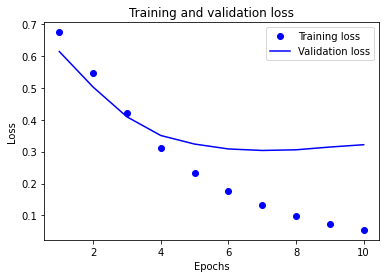

In [21]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'bo', label='Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Using [nnlm-en-dim128](https://tfhub.dev/google/nnlm-en-dim128/2)


Token based text embedding trained on English Google News 200B corpus.

Epoch 1/10
30/30 [==============================] - 7s 180ms/step - loss: 0.6486 - accuracy: 0.5361 - val_loss: 0.5231 - val_accuracy: 0.6884
Epoch 2/10
30/30 [==============================] - 6s 176ms/step - loss: 0.4518 - accuracy: 0.7760 - val_loss: 0.3773 - val_accuracy: 0.8313
Epoch 3/10
30/30 [==============================] - 6s 174ms/step - loss: 0.2831 - accuracy: 0.8911 - val_loss: 0.3181 - val_accuracy: 0.8676
Epoch 4/10
30/30 [==============================] - 6s 175ms/step - loss: 0.1841 - accuracy: 0.9394 - val_loss: 0.2949 - val_accuracy: 0.8729
Epoch 5/10
30/30 [==============================] - 6s 173ms/step - loss: 0.1190 - accuracy: 0.9687 - val_loss: 0.2938 - val_accuracy: 0.8774
Epoch 6/10
30/30 [==============================] - 6s 174ms/step - loss: 0.0769 - accuracy: 0.9839 - val_loss: 0.3045 - val_accuracy: 0.8752
Epoch 7/10
30/30 [==============================] - 6s 173ms/step - loss: 0.0497 - accuracy: 0.9922 - val_loss: 0.3215 - val_accuracy: 0.8758
Epoch 

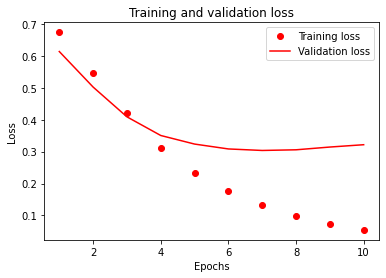

In [22]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer=hub.KerasLayer(embedding, 
                         input_shape=[],
                         dtype=tf.string,
                         trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'ro', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Using [nnlm-en-dim128-with-normalization](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2)


This can help if the text in your task contains additional characters or punctuation.

Epoch 1/10
30/30 [==============================] - 7s 187ms/step - loss: 0.6515 - accuracy: 0.5252 - val_loss: 0.4845 - val_accuracy: 0.7482
Epoch 2/10
30/30 [==============================] - 6s 182ms/step - loss: 0.4133 - accuracy: 0.8174 - val_loss: 0.3403 - val_accuracy: 0.8656
Epoch 3/10
30/30 [==============================] - 6s 181ms/step - loss: 0.2479 - accuracy: 0.9152 - val_loss: 0.2822 - val_accuracy: 0.8779
Epoch 4/10
30/30 [==============================] - 6s 182ms/step - loss: 0.1578 - accuracy: 0.9493 - val_loss: 0.2631 - val_accuracy: 0.8860
Epoch 5/10
30/30 [==============================] - 6s 184ms/step - loss: 0.0984 - accuracy: 0.9736 - val_loss: 0.2606 - val_accuracy: 0.8881
Epoch 6/10
30/30 [==============================] - 6s 183ms/step - loss: 0.0640 - accuracy: 0.9865 - val_loss: 0.2663 - val_accuracy: 0.8916
Epoch 7/10
30/30 [==============================] - 6s 181ms/step - loss: 0.0417 - accuracy: 0.9935 - val_loss: 0.2769 - val_accuracy: 0.8904
Epoch 

Exception ignored in: <function CapturableResourceDeleter.__del__ at 0x7fa03babb5f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/tracking/tracking.py", line 208, in __del__
    self._destroy_resource()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 828, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 871, in _call
    self._initialize(args, kwds, add_initializers_to=initializers)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 726, in _initialize
    *args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 2969, in _get_concrete_function_internal_garbage_collected
    graph_function, _ = self._maybe_define_function(args, kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/p

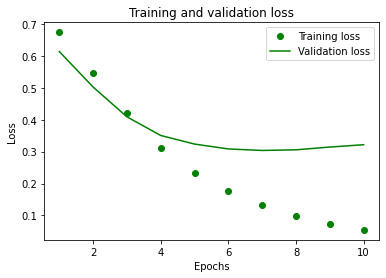

In [23]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer=hub.KerasLayer(embedding, 
                         input_shape=[],
                         dtype=tf.string,
                         trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'go', label='Training loss')
plt.plot(epochs, val_loss,'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

[Universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

Encoder of greater-than-word length text trained on a variety of data.

Epoch 1/10
30/30 [==============================] - 48s 1s/step - loss: 0.6222 - accuracy: 0.5756 - val_loss: 0.4011 - val_accuracy: 0.8163
Epoch 2/10
30/30 [==============================] - 42s 1s/step - loss: 0.2979 - accuracy: 0.8901 - val_loss: 0.2886 - val_accuracy: 0.8743
Epoch 3/10
30/30 [==============================] - 41s 1s/step - loss: 0.0948 - accuracy: 0.9770 - val_loss: 0.3332 - val_accuracy: 0.8850
Epoch 4/10
30/30 [==============================] - 41s 1s/step - loss: 0.0288 - accuracy: 0.9963 - val_loss: 0.3144 - val_accuracy: 0.8825
Epoch 5/10
30/30 [==============================] - 41s 1s/step - loss: 0.0129 - accuracy: 0.9985 - val_loss: 0.3317 - val_accuracy: 0.8879
Epoch 6/10
30/30 [==============================] - 41s 1s/step - loss: 0.0061 - accuracy: 0.9996 - val_loss: 0.3622 - val_accuracy: 0.8861
Epoch 7/10
30/30 [==============================] - 40s 1s/step - loss: 0.0040 - accuracy: 0.9998 - val_loss: 0.3783 - val_accuracy: 0.8892
Epoch 8/10
30/30 [==

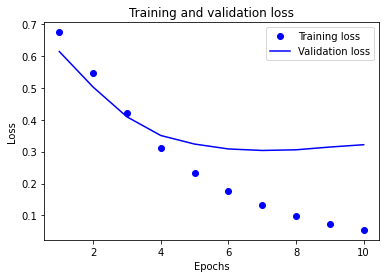

In [24]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer=hub.KerasLayer(embedding, 
                         input_shape=[],
                         dtype=tf.string,
                         trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'bo', label='Training loss')
plt.plot(epochs, val_loss,'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Change of activation function ( Sigmoid)

Epoch 1/10


30/30 [==============================] - 47s 1s/step - loss: 0.6761 - accuracy: 0.4997 - val_loss: 0.5373 - val_accuracy: 0.7067
Epoch 2/10
30/30 [==============================] - 40s 1s/step - loss: 0.4594 - accuracy: 0.8078 - val_loss: 0.3731 - val_accuracy: 0.8719
Epoch 3/10
30/30 [==============================] - 40s 1s/step - loss: 0.2194 - accuracy: 0.9589 - val_loss: 0.3295 - val_accuracy: 0.8653
Epoch 4/10
30/30 [==============================] - 40s 1s/step - loss: 0.1079 - accuracy: 0.9894 - val_loss: 0.2978 - val_accuracy: 0.8904
Epoch 5/10
30/30 [==============================] - 40s 1s/step - loss: 0.0704 - accuracy: 0.9950 - val_loss: 0.3484 - val_accuracy: 0.8690
Epoch 6/10
30/30 [==============================] - 40s 1s/step - loss: 0.0528 - accuracy: 0.9969 - val_loss: 0.3180 - val_accuracy: 0.8899
Epoch 7/10
30/30 [==============================] - 40s 1s/step - loss: 0.0418 - accuracy: 0.9977 - val_loss: 0.3349 - val_accuracy: 0.8860
Epoch 8/10
30/30 [=============

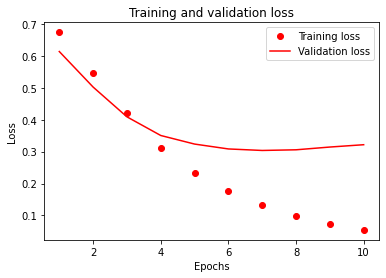

In [25]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer=hub.KerasLayer(embedding, 
                         input_shape=[],
                         dtype=tf.string,
                         trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'ro', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Change of architecture

Epoch 1/10


30/30 [==============================] - 50s 1s/step - loss: 0.7045 - accuracy: 0.5014 - val_loss: 0.6482 - val_accuracy: 0.4990
Epoch 2/10
30/30 [==============================] - 41s 1s/step - loss: 0.5802 - accuracy: 0.5954 - val_loss: 0.3425 - val_accuracy: 0.8660
Epoch 3/10
30/30 [==============================] - 41s 1s/step - loss: 0.2190 - accuracy: 0.9322 - val_loss: 0.2881 - val_accuracy: 0.8812
Epoch 4/10
30/30 [==============================] - 41s 1s/step - loss: 0.0711 - accuracy: 0.9853 - val_loss: 0.3074 - val_accuracy: 0.8906
Epoch 5/10
30/30 [==============================] - 41s 1s/step - loss: 0.0316 - accuracy: 0.9958 - val_loss: 0.3996 - val_accuracy: 0.8659
Epoch 6/10
30/30 [==============================] - 42s 1s/step - loss: 0.0216 - accuracy: 0.9973 - val_loss: 0.4522 - val_accuracy: 0.8791
Epoch 7/10
30/30 [==============================] - 41s 1s/step - loss: 0.0129 - accuracy: 0.9989 - val_loss: 0.4720 - val_accuracy: 0.8808
Epoch 8/10
30/30 [=============

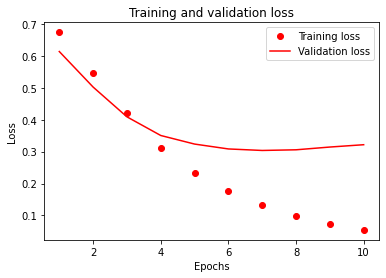

In [26]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer=hub.KerasLayer(embedding, 
                         input_shape=[],
                         dtype=tf.string,
                         trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(60, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs= range(1,len(acc)+1)

plt.plot(epochs,loss,'ro', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()